<a href="https://colab.research.google.com/github/AlexTako/AI_practice/blob/main/Dogs_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Тонкая настройка модели второй версии [EfficientNetV2](https://keras.io/api/applications/efficientnet_v2/) на примере набора данных [Stanford Dogs](https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip).

In [ ]:
# Ваше решение
import keras
print(keras.__version__)

2.15.0


In [ ]:
!pip install --upgrade keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.


In [ ]:
import keras
print(keras.__version__)

3.0.0


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow import data as tf_data
import os
import keras
from keras import layers
from keras.applications import EfficientNetV2B0

IMAGE_SIZE = (224, 224) # Размер определен выбором модели
BATCH_SIZE = 128

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip

--2024-03-11 08:01:06--  https://storage.yandexcloud.net/academy.ai/stanford_dogs.zip
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 774907490 (739M) [application/x-zip-compressed]
Saving to: ‘stanford_dogs.zip’

stanford_dogs.zip   100%[===================>] 739.01M  10.9MB/s    in 72s     

2024-03-11 08:02:19 (10.3 MB/s) - ‘stanford_dogs.zip’ saved [774907490/774907490]



In [ ]:
# Разархивируем датасета во временную папку 'temp'
!unzip -qo "stanford_dogs" -d ./dataset

# Папка с папками картинок, рассортированных по категориям
IMAGE_PATH = './dataset/'

In [ ]:
# Фильтруем поврежденные изображения
num_skipped = 0 # счетчик поврежденных файлов
for folder_name in os.listdir(IMAGE_PATH): # перебираем папки
    folder_path = os.path.join(IMAGE_PATH, folder_name) # склеиваем путь
    for fname in os.listdir(folder_path): # получаем список файлов в папке
        fpath = os.path.join(folder_path, fname) # получаем путь до файла
        try:
            fobj = open(fpath, "rb") # пытаемся открыть файл для бинарного чтения (rb)
            is_jfif = b"JFIF" in fobj.peek(10) # получаем первые 10 байт из файла и ищем в них бинарный вариант строки JFIF
        finally:
            fobj.close() # Закрываем файл

        if not is_jfif: # Если не нашли JFIF строку
            # Увеличиваем счетчик
            num_skipped += 1
            # Удаляем поврежденное изображение
            os.remove(fpath)

print(f"Удалено изображений: {num_skipped}")

Удалено изображений: 10


In [ ]:
# Генерируем датасет
train_ds, val_ds = keras.utils.image_dataset_from_directory(
    IMAGE_PATH, # путь к папке с данными
    validation_split=0.2, # отщепляем 20% на проверочную выборку
    subset="both", # указываем, что необходимо вернуть кортеж из обучающей и проверочной выборок ("training", "validation" или "both")
    seed=42,  # воспроизводимость результата генерации (результаты с одинаковым числом - одинаковы),
    shuffle=True, # перемешиваем датасет
    image_size=IMAGE_SIZE, # размер генерируемых изображений
    batch_size=BATCH_SIZE, # размер мини-батча
)

Found 20570 files belonging to 120 classes.
Using 16456 files for training.
Using 4114 files for validation.


In [ ]:
# Определяем список имен классов
CLASS_LIST = sorted(os.listdir(IMAGE_PATH))

# Определяем количества классов
CLASS_COUNT = len(CLASS_LIST)

# Вывод результата
print(f'Количество классов: {CLASS_COUNT}')
print(f'Метки классов: {CLASS_LIST}')

Количество классов: 120
Метки классов: ['Affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Basenji', 'Basset', 'Beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Black-and-tan_coonhound', 'Blenheim_spaniel', 'Bloodhound', 'Bluetick', 'Border_collie', 'Border_terrier', 'Borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'Boxer', 'Brabancon_griffon', 'Briard', 'Brittany_spaniel', 'Bull_mastiff', 'Cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Chow', 'Clumber', 'Cocker_spaniel', 'Collie', 'Curly-coated_retriever', 'Dandie_Dinmont', 'Dhole', 'Dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'Flat-coated_retriever', 'French_bulldog', 'German_shepherd', 'German_short-haired_pointer', 'Giant_schnauzer', 'Golden_retriever', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Groenendael', 'Ibizan_hound',

In [ ]:
# Проводим аугментацию данных (расширение)
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15), # Вращаем изображение в пределах 15%
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1), # Сдвиг на 10% по вертикали и горизонтали
    layers.RandomFlip(), # Отражение по вертикали и горизонтали
    layers.RandomContrast(factor=0.1), # Изменяем контрастность на 10%
]


def img_augmentation(images):
    # Слои - это функции, которые мы последовательно применяем к входным данным
    for layer in img_augmentation_layers:
        images = layer(images)
    return images

In [ ]:
# Применяем `img_augmentation` к обучающей выборке
train_ds = train_ds.map(
    lambda img, label: (img_augmentation(img), keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

val_ds = val_ds.map(
    lambda img, label: (img, keras.ops.one_hot(label, CLASS_COUNT)), # One-hot кодирование
    num_parallel_calls=tf_data.AUTOTUNE, # число потоков для обработки в map (автонастройка зависит от возможностей процессора)
)

# Предварительная выборка примеров в память GPU или оперативную память
# Помогает максимально эффективно использовать графический процессор
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
# Вспомогательная plot функция
def show_plot(history):
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')
    plt.plot(epochs, val_acc, 'b', label='Точность на проверочной выборке')
    plt.title('График точности на обучающей и проверочной выборках')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')
    plt.plot(epochs, val_loss, 'b', label='Потери на проверочной выборке')
    plt.title('График потерь на обучающей и проверочной выборках')
    plt.legend()
    plt.show()

In [ ]:
# Перенос обучения
def build_model(num_classes):
    inputs = layers.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    model = EfficientNetV2B0(include_top=False, input_tensor=inputs, weights="imagenet")

    # Заморозка предобученных весов
    model.trainable = False

    # Замена верхних слоев
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Компилируем
    model = keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )
    return model

In [ ]:
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath = 'best_model_pretrain.keras', # Будем сохранять лучший результат
                             monitor = 'val_acc',
                             save_best_only = True,
                             mode = 'max',
                             verbose = 0)
]

model = build_model(num_classes=CLASS_COUNT)


history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=callbacks)

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - acc: 0.3922 - loss: 3.3029 - val_acc: 0.7769 - val_loss: 0.7683
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - acc: 0.5857 - loss: 1.7186 - val_acc: 0.8143 - val_loss: 0.5999
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 305s 2s/step - acc: 0.6359 - loss: 1.3179 - val_acc: 0.8274 - val_loss: 0.5404
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - acc: 0.6575 - loss: 1.1922 - val_acc: 0.8442 - val_loss: 0.5000
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 279s 2s/step - acc: 0.6706 - loss: 1.1581 - val_acc: 0.8471 - val_loss: 0.4747
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 241s 2s/step - acc: 0.6767 - loss: 1.1371 - val_acc: 0.8354 - val_loss: 0.5025
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 262s 2s/step - acc: 0.6783 - loss: 1.1112 - val_acc: 0.8388 - val_loss: 0.4971
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - acc: 0.6810 - loss: 1.0814 - val_acc: 0.8415 - val_loss: 0.49

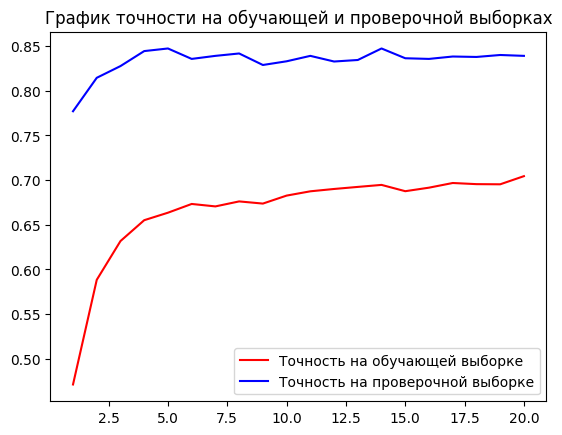

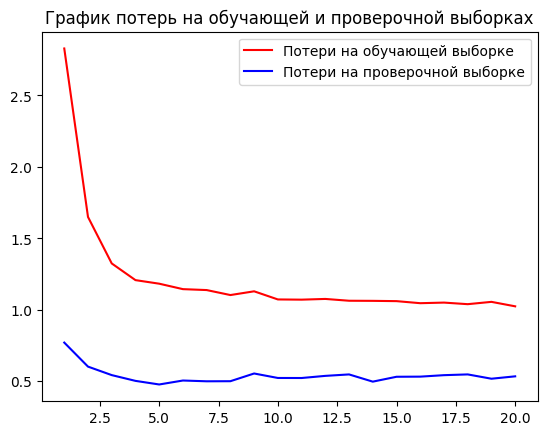

In [ ]:
show_plot(history)

In [ ]:
# Загружаем лучшую модель
from google.colab import files
files.download('best_model_pretrain.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - acc: 0.7050 - loss: 1.0072 - val_acc: 0.8442 - val_loss: 0.5119
Epoch 2/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 243s 2s/step - acc: 0.7234 - loss: 0.9378 - val_acc: 0.8483 - val_loss: 0.4976
Epoch 3/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 249s 2s/step - acc: 0.7229 - loss: 0.9528 - val_acc: 0.8525 - val_loss: 0.4883
Epoch 4/4
129/129 ━━━━━━━━━━━━━━━━━━━━ 248s 2s/step - acc: 0.7248 - loss: 0.9313 - val_acc: 0.8534 - val_loss: 0.4812


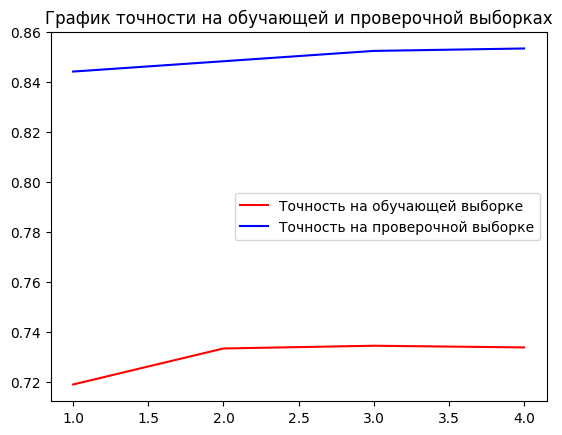

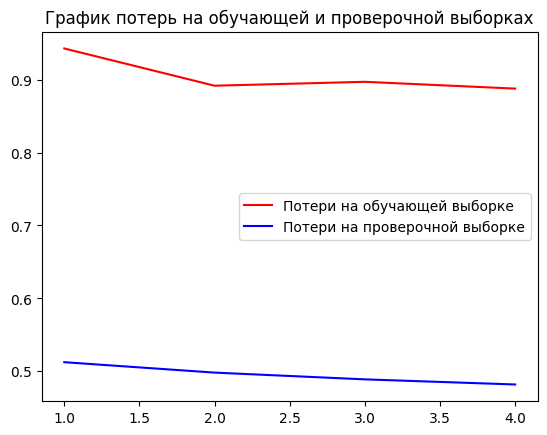

In [ ]:
# Размораживаем модель и уменьшаем шаг обучения
def unfreeze_model(model):
    # Мы размораживаем 20 верхних слоев за исключением BatchNormalization
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True
    # В оптимизаторе устанавливаем маленький шаг обучения
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["acc"]
    )


unfreeze_model(model)

epochs = 4
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)
show_plot(history)

--2024-03-11 10:01:28--  https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47310 (46K) [image/jpeg]
Saving to: ‘Cardigan.jpeg’

Cardigan.jpeg       100%[===================>]  46.20K   166KB/s    in 0.3s    

2024-03-11 10:01:31 (166 KB/s) - ‘Cardigan.jpeg’ saved [47310/47310]

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


(-0.5, 223.5, 223.5, -0.5)

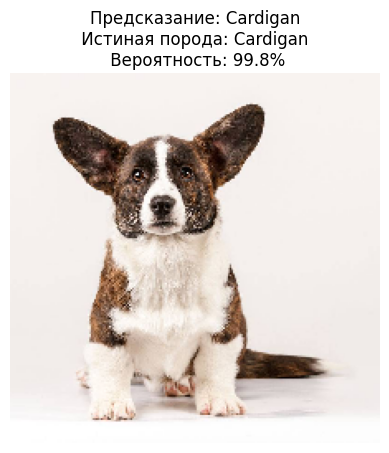

In [ ]:
# Проверяем модель на рандомных картинках из интернета
!wget https://storage.yandexcloud.net/academy.ai/Cardigan.jpeg
TEST_IMG='./Cardigan.jpeg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Cardigan \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:03:27--  https://porodysobak.ru/wp-content/uploads/2022/08/bigl.webp
Resolving porodysobak.ru (porodysobak.ru)... 92.53.96.222
Connecting to porodysobak.ru (porodysobak.ru)|92.53.96.222|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 136048 (133K) [image/webp]
Saving to: ‘bigl.webp.1’

bigl.webp.1         100%[===================>] 132.86K   252KB/s    in 0.5s    

2024-03-11 10:03:29 (252 KB/s) - ‘bigl.webp.1’ saved [136048/136048]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


(-0.5, 223.5, 223.5, -0.5)

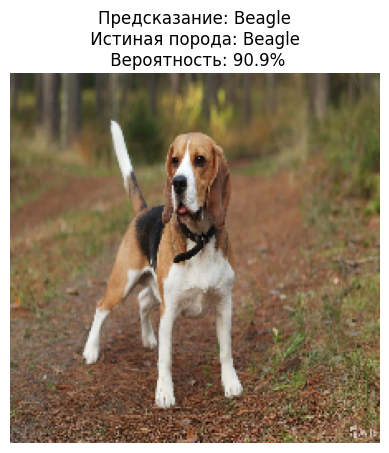

In [ ]:
!wget https://porodysobak.ru/wp-content/uploads/2022/08/bigl.webp
TEST_IMG='./bigl.webp'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Beagle \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:04:37--  https://gas-kvas.com/grafic/uploads/posts/2023-10/1696473099_gas-kvas-com-p-kartinki-ovcharka-nemetskaya-4.jpg
Resolving gas-kvas.com (gas-kvas.com)... 89.163.144.48
Connecting to gas-kvas.com (gas-kvas.com)|89.163.144.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282834 (276K) [image/jpeg]
Saving to: ‘1696473099_gas-kvas-com-p-kartinki-ovcharka-nemetskaya-4.jpg.1’

1696473099_gas-kvas 100%[===================>] 276.21K   560KB/s    in 0.5s    

2024-03-11 10:04:38 (560 KB/s) - ‘1696473099_gas-kvas-com-p-kartinki-ovcharka-nemetskaya-4.jpg.1’ saved [282834/282834]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


(-0.5, 223.5, 223.5, -0.5)

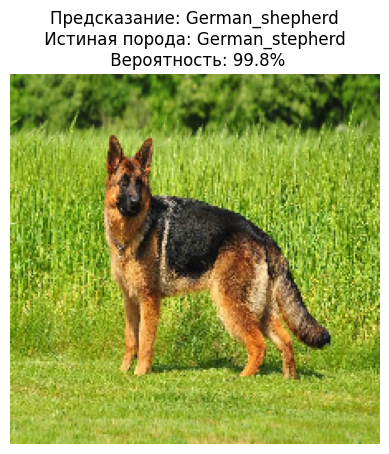

In [ ]:
!wget https://gas-kvas.com/grafic/uploads/posts/2023-10/1696473099_gas-kvas-com-p-kartinki-ovcharka-nemetskaya-4.jpg
TEST_IMG='./1696473099_gas-kvas-com-p-kartinki-ovcharka-nemetskaya-4.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: German_stepherd \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:05:27--  https://cepia.ru/images/u/pages/1197/mops-14.jpg
Resolving cepia.ru (cepia.ru)... 90.156.201.114, 90.156.201.52, 90.156.201.110, ...
Connecting to cepia.ru (cepia.ru)|90.156.201.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258375 (252K) [image/jpeg]
Saving to: ‘mops-14.jpg.1’

mops-14.jpg.1       100%[===================>] 252.32K   248KB/s    in 1.0s    

2024-03-11 10:05:29 (248 KB/s) - ‘mops-14.jpg.1’ saved [258375/258375]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


(-0.5, 223.5, 223.5, -0.5)

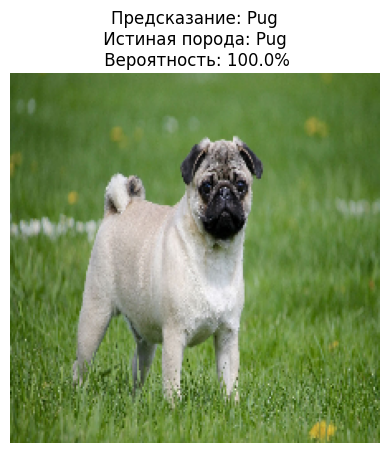

In [ ]:
!wget https://cepia.ru/images/u/pages/1197/mops-14.jpg
TEST_IMG='./mops-14.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Pug \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:06:29--  https://for-pet.ru/wp-content/uploads/2020/04/doberman.jpg
Resolving for-pet.ru (for-pet.ru)... 45.130.41.254
Connecting to for-pet.ru (for-pet.ru)|45.130.41.254|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182632 (178K) [image/jpeg]
Saving to: ‘doberman.jpg.1’

doberman.jpg.1      100%[===================>] 178.35K   285KB/s    in 0.6s    

2024-03-11 10:06:31 (285 KB/s) - ‘doberman.jpg.1’ saved [182632/182632]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(-0.5, 223.5, 223.5, -0.5)

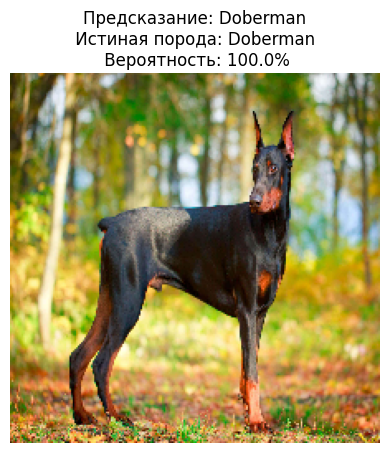

In [ ]:
!wget https://for-pet.ru/wp-content/uploads/2020/04/doberman.jpg
TEST_IMG='./doberman.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Doberman \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:08:22--  https://gas-kvas.com/grafic/uploads/posts/2023-09/1695881151_gas-kvas-com-p-kartinki-korgi-4.jpg
Resolving gas-kvas.com (gas-kvas.com)... 89.163.144.48
Connecting to gas-kvas.com (gas-kvas.com)|89.163.144.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244027 (238K) [image/jpeg]
Saving to: ‘1695881151_gas-kvas-com-p-kartinki-korgi-4.jpg.1’

1695881151_gas-kvas 100%[===================>] 238.31K   492KB/s    in 0.5s    

2024-03-11 10:08:23 (492 KB/s) - ‘1695881151_gas-kvas-com-p-kartinki-korgi-4.jpg.1’ saved [244027/244027]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


(-0.5, 223.5, 223.5, -0.5)

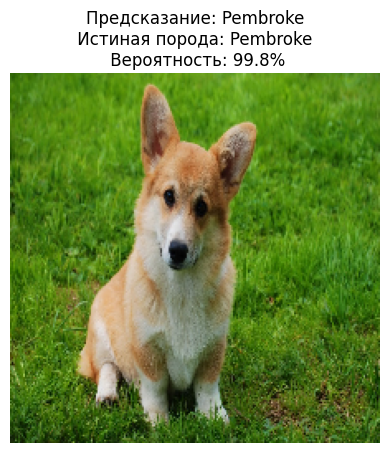

In [ ]:
!wget https://gas-kvas.com/grafic/uploads/posts/2023-09/1695881151_gas-kvas-com-p-kartinki-korgi-4.jpg
TEST_IMG='./1695881151_gas-kvas-com-p-kartinki-korgi-4.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Pembroke \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:09:20--  http://cache3.youla.io/files/images/780_780/5c/ee/5ceea369c6ab9e32c36dde66.jpg
Resolving cache3.youla.io (cache3.youla.io)... 95.163.42.203
Connecting to cache3.youla.io (cache3.youla.io)|95.163.42.203|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60806 (59K) [image/jpeg]
Saving to: ‘5ceea369c6ab9e32c36dde66.jpg.1’

5ceea369c6ab9e32c36 100%[===================>]  59.38K   110KB/s    in 0.5s    

2024-03-11 10:09:21 (110 KB/s) - ‘5ceea369c6ab9e32c36dde66.jpg.1’ saved [60806/60806]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


(-0.5, 223.5, 223.5, -0.5)

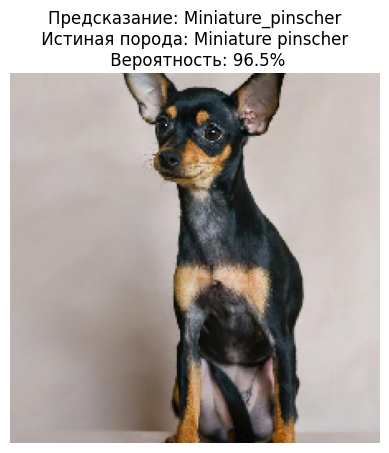

In [ ]:
!wget http://cache3.youla.io/files/images/780_780/5c/ee/5ceea369c6ab9e32c36dde66.jpg
TEST_IMG='./5ceea369c6ab9e32c36dde66.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Miniature pinscher \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:10:04--  https://wdorogu.ru/wp-content/uploads/2022/09/219.jpg
Resolving wdorogu.ru (wdorogu.ru)... 109.236.88.95
Connecting to wdorogu.ru (wdorogu.ru)|109.236.88.95|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169139 (165K) [image/jpeg]
Saving to: ‘219.jpg.1’

219.jpg.1           100%[===================>] 165.17K   494KB/s    in 0.3s    

2024-03-11 10:10:05 (494 KB/s) - ‘219.jpg.1’ saved [169139/169139]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


(-0.5, 223.5, 223.5, -0.5)

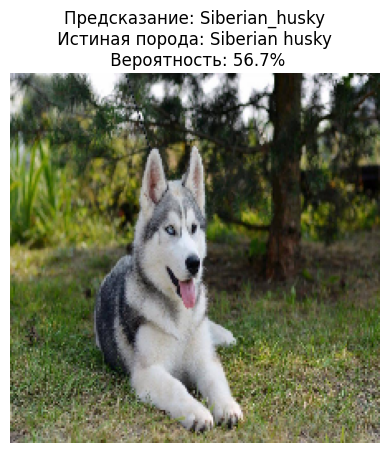

In [ ]:
!wget https://wdorogu.ru/wp-content/uploads/2022/09/219.jpg
TEST_IMG='./219.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Siberian husky \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:13:23--  https://fikiwiki.com/uploads/posts/2022-02/1644900672_3-fikiwiki-com-p-kartinki-labradori-3.jpg
Resolving fikiwiki.com (fikiwiki.com)... 45.130.41.26
Connecting to fikiwiki.com (fikiwiki.com)|45.130.41.26|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 529089 (517K) [image/jpeg]
Saving to: ‘1644900672_3-fikiwiki-com-p-kartinki-labradori-3.jpg.1’

1644900672_3-fikiwi 100%[===================>] 516.69K   459KB/s    in 1.1s    

2024-03-11 10:13:26 (459 KB/s) - ‘1644900672_3-fikiwiki-com-p-kartinki-labradori-3.jpg.1’ saved [529089/529089]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


(-0.5, 223.5, 223.5, -0.5)

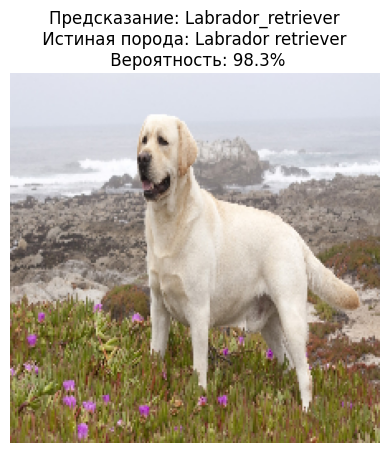

In [ ]:
!wget https://fikiwiki.com/uploads/posts/2022-02/1644900672_3-fikiwiki-com-p-kartinki-labradori-3.jpg
TEST_IMG='./1644900672_3-fikiwiki-com-p-kartinki-labradori-3.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Labrador retriever \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

--2024-03-11 10:14:18--  https://attuale.ru/wp-content/uploads/2018/08/staffordshire-terrier.jpg
Resolving attuale.ru (attuale.ru)... 45.88.104.28
Connecting to attuale.ru (attuale.ru)|45.88.104.28|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43381 (42K) [image/jpeg]
Saving to: ‘staffordshire-terrier.jpg.1’

staffordshire-terri 100%[===================>]  42.36K   257KB/s    in 0.2s    

2024-03-11 10:14:19 (257 KB/s) - ‘staffordshire-terrier.jpg.1’ saved [43381/43381]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


(-0.5, 223.5, 223.5, -0.5)

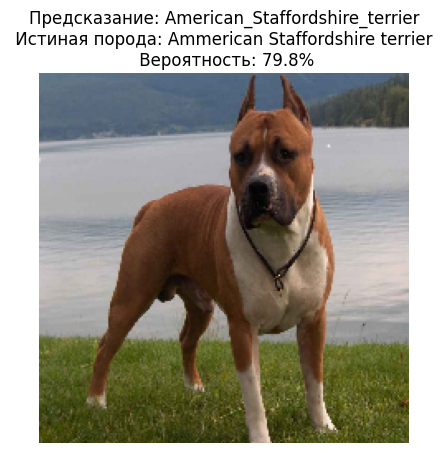

In [ ]:
!wget https://attuale.ru/wp-content/uploads/2018/08/staffordshire-terrier.jpg
TEST_IMG='./staffordshire-terrier.jpg'

img = keras.utils.load_img(TEST_IMG, target_size=(IMAGE_SIZE[0], IMAGE_SIZE[1])) # Загружаем картинку
plt.imshow(img)


img_array = keras.utils.img_to_array(img) # Преобразуем картинку в тензор
img_array = keras.ops.expand_dims(img_array, 0)  # Создание дополнительного измерения для батча

predictions = model.predict(img_array)


plt.title("Предсказание: %s\n Истиная порода: Ammerican Staffordshire terrier \n Вероятность: %2.1f%%" %
 (CLASS_LIST[keras.ops.argmax(predictions)],
  keras.ops.max(predictions)*100)  ) # Вывод метки
plt.axis("off")

**Примечание**. В 2021 году появилась вторая версия модели EfficientNetV2 (https://arxiv.org/pdf/2104.00298.pdf), которая была добавлена в Keras.